In [1]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.431896  6.446622  6.382907  6.414464  493729600
2010-01-05  6.443017  6.479383  6.409055  6.449629  601904800
2010-01-06  6.340531  6.468562  6.333919  6.443016  552160000
2010-01-07  6.328809  6.371486  6.282826  6.363973  477131200
2010-01-08  6.370887  6.371488  6.283129  6.320396  447610800
Training data shape: X=(3163, 60, 7), y=(3163,)
Epoch 1/50



C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0188
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0012
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0011
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0010
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0011
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 9.2089e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0010
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.1274e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.6071e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.3352e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.0509e-04
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0011
Epoch 13/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.7990e-04
Epoch 14/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.9871e-04
Epoch 15/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - 

[*********************100%***********************]  1 of 1 completed

Test data shape: X=(141, 60, 7), y=(141,)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


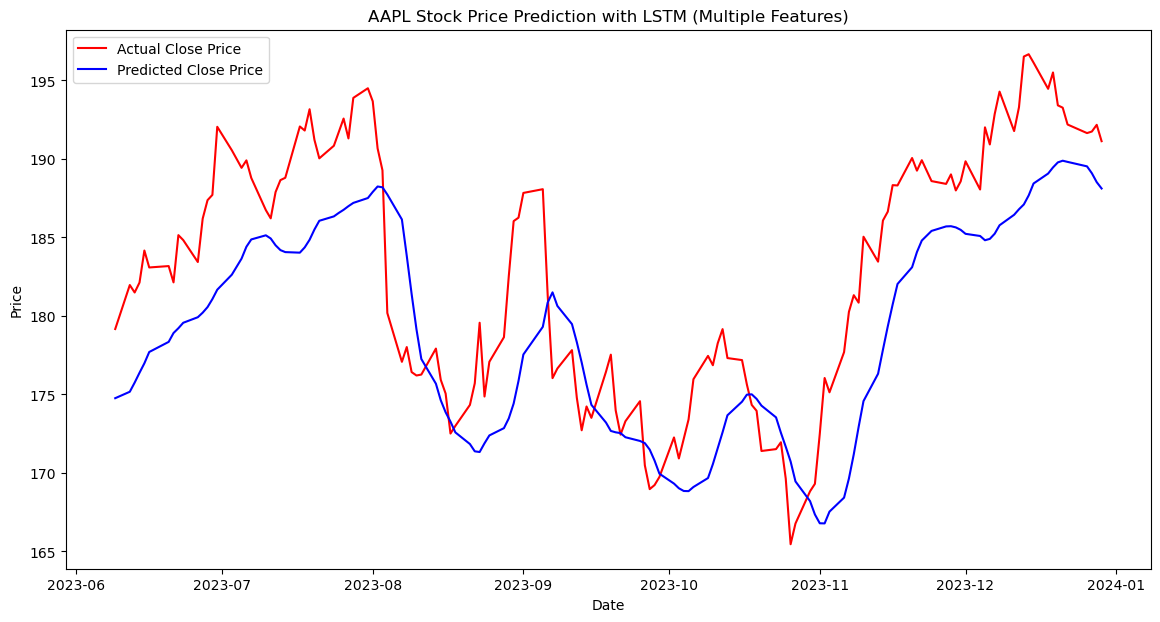

Mean Absolute Error (MAE): 4.82
Custom Accuracy (within ±$5): 52.48%


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error


ticker = 'AAPL' 
start_date = '2010-01-01'
end_date = '2023-01-01'

data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
print(data.head())


data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()


data.dropna(inplace=True)


features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA10', 'MA50']
target = 'Close'


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(data[features])


look_back = 60
X_train, y_train = [], []

for i in range(look_back, len(scaled_features)):
    X_train.append(scaled_features[i - look_back:i])
    y_train.append(scaled_features[i][features.index(target)]) 

X_train, y_train = np.array(X_train), np.array(y_train)

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")


model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  

model.compile(optimizer='adam', loss='mean_squared_error')


early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)


model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stop])


test_start_date = '2023-01-02'
test_end_date = '2023-12-31'

test_data = yf.download(ticker, start=test_start_date, end=test_end_date, auto_adjust=True)


test_data['MA10'] = test_data['Close'].rolling(window=10).mean()
test_data['MA50'] = test_data['Close'].rolling(window=50).mean()
test_data.dropna(inplace=True)


scaled_test_features = scaler.transform(test_data[features])

X_test, y_test = [], []

for i in range(look_back, len(scaled_test_features)):
    X_test.append(scaled_test_features[i - look_back:i])
    y_test.append(scaled_test_features[i][features.index(target)])

X_test, y_test = np.array(X_test), np.array(y_test)

print(f"Test data shape: X={X_test.shape}, y={y_test.shape}")


predicted_scaled = model.predict(X_test)


dummy_test = np.zeros((len(predicted_scaled), len(features)))
dummy_test[:, features.index(target)] = predicted_scaled[:, 0]
predicted_price = scaler.inverse_transform(dummy_test)[:, features.index(target)]


dummy_actual = np.zeros((len(y_test), len(features)))
dummy_actual[:, features.index(target)] = y_test
actual_price = scaler.inverse_transform(dummy_actual)[:, features.index(target)]


plt.figure(figsize=(14, 7))
plt.plot(test_data.index[look_back:], actual_price, color='red', label='Actual Close Price')
plt.plot(test_data.index[look_back:], predicted_price, color='blue', label='Predicted Close Price')
plt.title(f'{ticker} Stock Price Prediction with LSTM (Multiple Features)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


mae = mean_absolute_error(actual_price, predicted_price)
print(f"Mean Absolute Error (MAE): {mae:.2f}")


threshold = 5
accuracy = np.mean(np.abs(actual_price - predicted_price) <= threshold) * 100
print(f"Custom Accuracy (within ±${threshold}): {accuracy:.2f}%")


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open    Volume
Ticker           MSFT       MSFT       MSFT       MSFT      MSFT
Date                                                            
2010-01-04  23.211439  23.323934  22.941451  22.963951  38409100
2010-01-05  23.218941  23.323937  22.978952  23.136445  49749600
2010-01-06  23.076447  23.308936  22.888955  23.158942  58182400
2010-01-07  22.836458  23.023950  22.641467  22.971451  50559700
2010-01-08  22.993950  23.158942  22.678964  22.708964  51197400
Training data shape: X=(3163, 60, 7), y=(3163,)
Epoch 1/50



C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0091
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0011
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.4933e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 8.8157e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.2348e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 7.6149e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0011
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.4176e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0011
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.3675e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 7.3932e-04
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 7.2497e-04
Epoch 13/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 8.0843e-04
Epoch 14/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.6021e-04
Epoch 15/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 

[*********************100%***********************]  1 of 1 completed

Test data shape: X=(141, 60, 7), y=(141,)
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


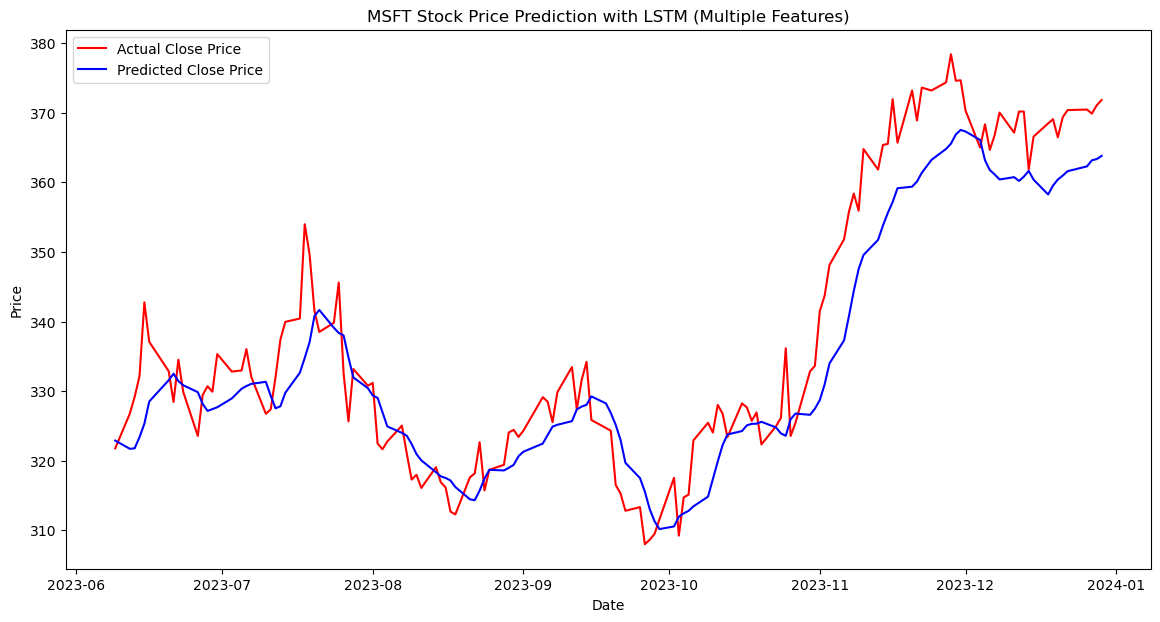

Mean Absolute Error (MAE): 5.84
Custom Accuracy (within ±$5): 47.52%


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error


ticker = 'MSFT'  
start_date = '2010-01-01'
end_date = '2023-01-01'

data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
print(data.head())


data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()


data.dropna(inplace=True)


features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA10', 'MA50']
target = 'Close'


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(data[features])


look_back = 60
X_train, y_train = [], []

for i in range(look_back, len(scaled_features)):
    X_train.append(scaled_features[i - look_back:i])
    y_train.append(scaled_features[i][features.index(target)])  

X_train, y_train = np.array(X_train), np.array(y_train)

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")


model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  

model.compile(optimizer='adam', loss='mean_squared_error')


early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)


model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stop])


test_start_date = '2023-01-02'
test_end_date = '2023-12-31'

test_data = yf.download(ticker, start=test_start_date, end=test_end_date, auto_adjust=True)


test_data['MA10'] = test_data['Close'].rolling(window=10).mean()
test_data['MA50'] = test_data['Close'].rolling(window=50).mean()
test_data.dropna(inplace=True)


scaled_test_features = scaler.transform(test_data[features])

X_test, y_test = [], []

for i in range(look_back, len(scaled_test_features)):
    X_test.append(scaled_test_features[i - look_back:i])
    y_test.append(scaled_test_features[i][features.index(target)])

X_test, y_test = np.array(X_test), np.array(y_test)

print(f"Test data shape: X={X_test.shape}, y={y_test.shape}")

# 8. Predict
predicted_scaled = model.predict(X_test)


dummy_test = np.zeros((len(predicted_scaled), len(features)))
dummy_test[:, features.index(target)] = predicted_scaled[:, 0]
predicted_price = scaler.inverse_transform(dummy_test)[:, features.index(target)]


dummy_actual = np.zeros((len(y_test), len(features)))
dummy_actual[:, features.index(target)] = y_test
actual_price = scaler.inverse_transform(dummy_actual)[:, features.index(target)]


plt.figure(figsize=(14, 7))
plt.plot(test_data.index[look_back:], actual_price, color='red', label='Actual Close Price')
plt.plot(test_data.index[look_back:], predicted_price, color='blue', label='Predicted Close Price')
plt.title(f'{ticker} Stock Price Prediction with LSTM (Multiple Features)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


mae = mean_absolute_error(actual_price, predicted_price)
print(f"Mean Absolute Error (MAE): {mae:.2f}")


threshold = 5
accuracy = np.mean(np.abs(actual_price - predicted_price) <= threshold) * 100
print(f"Custom Accuracy (within ±${threshold}): {accuracy:.2f}%")
